In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
from dateutil.parser import parse
from dataset import Dataset
from portfolio import Portfolio

In [2]:
def get_thr(l, std_ratio=3):
    m = np.mean(l)
    thr = 0
    while thr < std_ratio:
        ll = l.copy()
        ll.append(m)
        thr = (m - np.mean(ll)) / np.std(ll)
        m += 1
    return m - 1

In [61]:
tf_hours = 1

start_date = parse('2022-01-01')
end_date = datetime.datetime.now() + datetime.timedelta(days=1)
days = (end_date - start_date).days
print(f'{days = }')

data = Dataset().get_data(ticker='BTCUSDT', interval=f'{tf_hours}h', start_date=start_date.strftime('%Y-%m-%d'),
                          end_date=end_date.strftime('%Y-%m-%d'))

days = 606


In [62]:
data = data[['open', 'high', 'low', 'close']]

In [63]:
data['candle_size'] = data['high'] - data['low']
data['candle_size_mean'] = data['candle_size'].rolling(14).mean()
data['candle_size_std'] = data['candle_size'].rolling(14).std()
data['std_ratio'] = (data['candle_size'] - data['candle_size_mean']) / data['candle_size_std']

In [64]:
data.tail()

,open,high,low,close,candle_size,candle_size_mean,candle_size_std,std_ratio
time,,,,,,,,
2023-08-29 18:00:00,27999.99,28097.91,27793.33,27892.07,304.58,263.070000,444.601023,0.093365
2023-08-29 19:00:00,27892.08,28020.73,27835.84,27971.79,184.89,273.393571,440.692742,-0.200828
2023-08-29 20:00:00,27971.78,27995.00,27823.91,27831.33,171.09,281.113571,437.660002,-0.251391
2023-08-29 21:00:00,27831.33,27883.61,27561.24,27569.28,322.37,299.842857,433.063524,0.052018
2023-08-29 22:00:00,27569.28,27650.00,27564.39,27633.12,85.61,301.768571,431.967058,-0.500405


In [65]:
data['std_ratio'].max()

3.469443395470328

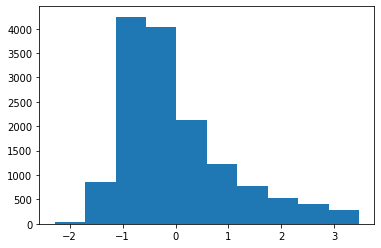

In [66]:
plt.hist(data['std_ratio'], bins=10)
plt.show()

In [67]:
std_multiple = 3
data_high_vol = data[data['std_ratio'] >= std_multiple]

In [68]:
data_high_vol.head()

,open,high,low,close,candle_size,candle_size_mean,candle_size_std,std_ratio
time,,,,,,,,
2022-01-07 04:00:00,42799.12,42827.07,41577.77,41803.11,1249.30,399.013571,265.628783,3.201033
2022-01-10 15:00:00,40774.01,41275.92,39650.00,40786.57,1625.92,401.798571,375.467522,3.260259
2022-01-12 12:00:00,42765.18,43443.60,42683.21,42935.92,760.39,282.051429,149.616642,3.197095
2022-01-13 15:00:00,43924.61,44500.00,43840.28,44154.52,659.72,265.218571,123.915523,3.183632
2022-01-13 16:00:00,44154.52,44211.00,42871.01,43200.00,1339.99,340.077857,313.243513,3.192124


In [69]:
data_high_vol.shape

(225, 8)

In [70]:
data_high_vol['std_ratio'].mean(), data_high_vol['std_ratio'].std()

(3.1911171556684494, 0.12229122090968167)

In [71]:
t = 1
for idx, candle in data_high_vol.iterrows():
    print(f'{t} / {data_high_vol.shape[0]}')
    t += 1
    last_sizes = list(data.loc[:idx].iloc[-14:-1]['candle_size'])
    entry_range = get_thr(last_sizes, std_multiple)
    
    start_date = idx - datetime.timedelta(minutes=tf_hours * 60)
    end_date = idx - datetime.timedelta(minutes=1)
    data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
                                 end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
    for i in data_1m.index:
        data_1m.loc[i, 'roll_high'] = data_1m.loc[:i]['high'].max()
        data_1m.loc[i, 'roll_low'] = data_1m.loc[:i]['low'].min()
    data_1m['roll_candle_size'] = data_1m['roll_high'] - data_1m['roll_low']
    rough_price = data_1m[data_1m['roll_candle_size'] > entry_range].iloc[0]['close']
    
    if rough_price > candle['open']:
        entry = candle['low'] + entry_range
        exit = candle['close']
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
        data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
    elif rough_price < candle['open']:
        entry = candle['high'] - entry_range
        exit = candle['close']
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
        data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
    else:
        data_high_vol.loc[idx, 'entry'] = np.nan
        data_high_vol.loc[idx, 'exit'] = np.nan
        data_high_vol.loc[idx, 'return_pct'] = 0
        data_high_vol.loc[idx, 'darwdown'] = 0

1 / 225


C:\Users\aeali\AppData\Local\Temp\ipykernel_14692\1303148757.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14692\1303148757.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14692\1303148757.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

2 / 225
3 / 225
4 / 225
5 / 225
6 / 225
7 / 225
8 / 225
9 / 225
10 / 225
11 / 225
12 / 225
13 / 225
14 / 225
15 / 225
16 / 225
17 / 225
18 / 225
19 / 225
20 / 225
21 / 225
22 / 225
23 / 225
24 / 225
25 / 225
26 / 225
27 / 225
28 / 225
29 / 225
30 / 225
31 / 225
32 / 225
33 / 225
34 / 225
35 / 225
36 / 225
37 / 225
38 / 225
39 / 225
40 / 225
41 / 225
42 / 225
43 / 225
44 / 225
45 / 225
46 / 225
47 / 225
48 / 225
49 / 225
50 / 225
51 / 225
52 / 225
53 / 225
54 / 225
55 / 225
56 / 225
57 / 225
58 / 225
59 / 225
60 / 225
61 / 225
62 / 225
63 / 225
64 / 225
65 / 225
66 / 225
67 / 225
68 / 225
69 / 225
70 / 225
71 / 225
72 / 225
73 / 225
74 / 225
75 / 225
76 / 225
77 / 225
78 / 225
79 / 225
80 / 225
81 / 225
82 / 225
83 / 225
84 / 225
85 / 225
86 / 225
87 / 225
88 / 225
89 / 225
90 / 225
91 / 225
92 / 225
93 / 225
94 / 225
95 / 225
96 / 225
97 / 225
98 / 225
99 / 225
100 / 225
101 / 225
102 / 225
103 / 225
104 / 225
105 / 225
106 / 225
107 / 225
108 / 225
109 / 225
110 / 225
111 / 225
112 / 

In [54]:
# t = 1
# for idx, candle in data_high_vol.iterrows():
#     print(f'{t} / {data_high_vol.shape[0]}')
#     t += 1
#     entry_range = candle['candle_size_mean'] + std_multiple * candle['candle_size_std']
    
#     start_date = idx - datetime.timedelta(minutes=tf_hours * 60)
#     end_date = idx - datetime.timedelta(minutes=1)
#     data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
#                                  end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
#     for i in data_1m.index:
#         data_1m.loc[i, 'roll_high'] = data_1m.loc[:i]['high'].max()
#         data_1m.loc[i, 'roll_low'] = data_1m.loc[:i]['low'].min()
#     data_1m['roll_candle_size'] = data_1m['roll_high'] - data_1m['roll_low']
#     rough_price = data_1m[data_1m['roll_candle_size'] > entry_range].iloc[0]['close']
    
#     if rough_price > candle['open']:
#         entry = candle['low'] + entry_range
#         exit = candle['close']
#         data_high_vol.loc[idx, 'entry'] = entry
#         data_high_vol.loc[idx, 'exit'] = exit
#         data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
#         data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
#     elif rough_price < candle['open']:
#         entry = candle['high'] - entry_range
#         exit = candle['close']
#         data_high_vol.loc[idx, 'entry'] = entry
#         data_high_vol.loc[idx, 'exit'] = exit
#         data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
#         data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
#     else:
#         data_high_vol.loc[idx, 'entry'] = np.nan
#         data_high_vol.loc[idx, 'exit'] = np.nan
#         data_high_vol.loc[idx, 'return_pct'] = 0
#         data_high_vol.loc[idx, 'darwdown'] = 0

In [72]:
data_high_vol['darwdown'].max()

0.05630593320263191

In [56]:
# for idx, candle in data_high_vol.iterrows():
#     start_date = idx - datetime.timedelta(minutes=tf_hours * 60 - 1)
#     end_date = idx
#     data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
#                                  end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
#     high_idx = data_1m.index[data_1m['high'].argmax()]
#     low_idx = data_1m.index[data_1m['low'].argmin()]
#     if high_idx > low_idx:
#         entry = candle['low'] + candle['candle_size_mean'] + std_multiple * candle['candle_size_std']
#         exit = candle['close']
#         data_high_vol.loc[idx, 'entry'] = entry
#         data_high_vol.loc[idx, 'exit'] = exit
#         data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
#         data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
#     elif high_idx < low_idx:
#         entry = candle['high'] - (candle['candle_size_mean'] + std_multiple * candle['candle_size_std'])
#         exit = candle['close']
#         data_high_vol.loc[idx, 'entry'] = entry
#         data_high_vol.loc[idx, 'exit'] = exit
#         data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
#         data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
#     else:
#         data_high_vol.loc[idx, 'entry'] = np.nan
#         data_high_vol.loc[idx, 'exit'] = np.nan
#         data_high_vol.loc[idx, 'return_pct'] = 0
#         data_high_vol.loc[idx, 'darwdown'] = 0

In [73]:
winrate = data_high_vol[data_high_vol['return_pct'] > 0].shape[0] / data_high_vol.shape[0]
winrate

0.43555555555555553

In [74]:
(data_high_vol['return_pct'].max(), data_high_vol['return_pct'].min(),
data_high_vol['return_pct'].mean(), data_high_vol['return_pct'].std())

(0.03527626184622741,
 -0.047537982428501206,
 -0.0018025429310974622,
 0.008731448929024582)

In [75]:
(data_high_vol['darwdown'].max(), data_high_vol['darwdown'].min(),
data_high_vol['darwdown'].mean(), data_high_vol['darwdown'].std())

(0.05630593320263191,
 0.0007576108112104049,
 0.008473323803690579,
 0.00873460891014604)

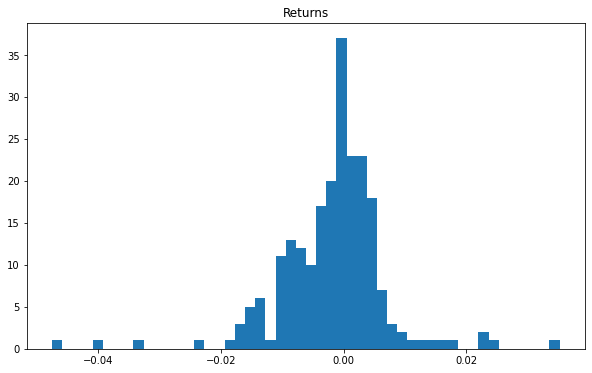

In [76]:
plt.figure(figsize=(10, 6))
plt.hist(data_high_vol['return_pct'], bins=50)
plt.title('Returns')
plt.show()

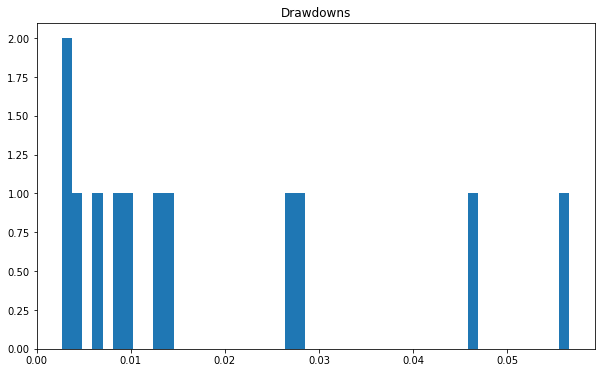

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(data_high_vol['darwdown'], bins=50)
plt.title('Drawdowns')
plt.show()

In [33]:
max_drawdown = 0.1

In [34]:
data_high_vol['darwdown'].mean() + 5 * data_high_vol['darwdown'].std()

0.10690927556555116

In [35]:
data_high_vol['return_pct_tot'] = 1 + data_high_vol['return_pct']

C:\Users\aeali\AppData\Local\Temp\ipykernel_14692\2964797260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol['return_pct_tot'] = 1 + data_high_vol['return_pct']


In [36]:
monthly_returns = data_high_vol['return_pct_tot'].resample('M').prod() - 1
monthly_returns

time
2023-01-31    0.000078
2023-02-28    0.000000
2023-03-31   -0.032308
2023-04-30   -0.000983
2023-05-31    0.024562
2023-06-30    0.005132
2023-07-31    0.000000
2023-08-31   -0.041891
Freq: M, Name: return_pct_tot, dtype: float64

In [37]:
monthly_returns.mean(), monthly_returns.std()

(-0.005676204305176097, 0.021285526006061026)

In [38]:
sharpe_ratio = (monthly_returns.mean() - 0.004) / monthly_returns.std()
sharpe_ratio

-0.45459080045383

In [39]:
leverage = max_drawdown / (data_high_vol['darwdown'].mean() + 5 * data_high_vol['darwdown'].std())
leverage

0.9353725340574892

In [41]:
taker_fee = 0.00055

<AxesSubplot:xlabel='time'>

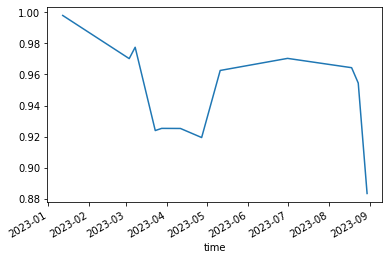

In [42]:
(leverage * (data_high_vol['return_pct'] - 2 * taker_fee) + 1).cumprod().plot()

In [93]:
start_cash = 1000
risk = 1
leverage = 10
pf = Portfolio(start_cash=start_cash, max_pos_pct=1, max_leverage=100, maker_fee=0.0002, taker_fee=0.00055)

t = 1
for idx, candle in data_high_vol.iterrows():
    print(f'{t} / {data_high_vol.shape[0]}')
    t += 1
    entry_range = candle['candle_size_mean'] + std_multiple * candle['candle_size_std']
    
    start_date = idx - datetime.timedelta(minutes=tf_hours * 60)
    end_date = idx - datetime.timedelta(minutes=1)
    data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
                                 end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
    for i in data_1m.index:
        data_1m.loc[i, 'roll_high'] = data_1m.loc[:i]['high'].max()
        data_1m.loc[i, 'roll_low'] = data_1m.loc[:i]['low'].min()
    data_1m['roll_candle_size'] = data_1m['roll_high'] - data_1m['roll_low']
    rough_price = data_1m[data_1m['roll_candle_size'] > entry_range].iloc[0]['close']
    
    if rough_price > candle['open']:
        entry = candle['low'] + entry_range
        exit = candle['close']
        
        pf.open_trade(entry, sl=1000000, tp=0, date=idx, risk=risk, lev=leverage)
        if exit <= entry:
            pf.take_profit(tp=exit, date=idx, order_type='market')
        else:
            pf.stop_loss(sl=exit, date=idx)
        
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
        data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
    elif rough_price < candle['open']:
        entry = candle['high'] - entry_range
        exit = candle['close']
        
        pf.open_trade(entry, sl=0, tp=1000000, date=idx, risk=risk, lev=leverage)
        if exit >= entry:
            pf.take_profit(tp=exit, date=idx, order_type='market')
        else:
            pf.stop_loss(sl=exit, date=idx)  
        
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
        data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
    else:
        data_high_vol.loc[idx, 'entry'] = np.nan
        data_high_vol.loc[idx, 'exit'] = np.nan
        data_high_vol.loc[idx, 'return_pct'] = 0
        data_high_vol.loc[idx, 'darwdown'] = 0

1 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

2 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

3 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

4 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

5 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

6 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

7 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

8 / 244


C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_8856\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx,

9 / 244


KeyboardInterrupt: 

In [ ]:
pf.trade_ts